In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

from scipy.io import loadmat
import networkx as nx

from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import lsq_linear

import seaborn as sns
from sklearn import linear_model
import os
import time

from scipy.linalg import solve_discrete_lyapunov, solve_continuous_lyapunov

import json

import operator
import regex as re
from scipy.linalg import expm
#from numpy.linalg import matrix_rank
from networkx.algorithms import bipartite
from networkx.algorithms import components
import random
from scipy.spatial import distance


from scipy.linalg import svd

In [6]:

# sort the names in alphanumeric order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(data, key=alphanum_key)

# Create a directed network by passing adjacency matrix
def get_graph_from_adjacency(adjacency):        
    nodes_list = []
    for i in range( adjacency.shape[0] ):
        #node attribute is given by its neuron name
        nodes_list.append((i+1)) #,{"name":neuron_names[i]}))
    #print(len(nodes_list))

    # creating an edge list from adjacency matrix
    edge_list=[]
    for i in range( adjacency.shape[0] ) :
        for j in range(adjacency.shape[0]):
            if adjacency[i,j]==0: # if there's no weight, let's forget the edge.
                pass
            else:
                edge_list.append( (i+1,j+1,{"weight":adjacency[i,j]}) )
    # Creating a directed graph from adjacency matrix so that it will be easy to deal using the networkx module

    G = nx.DiGraph()

    # Add all the nodes to the graph
    G.add_nodes_from(nodes_list)
    # Add all the edges to the graph
    G.add_edges_from(edge_list)
    return G

# construct input matrix B by passing a list of unmatched nodes
def compute_B(N, unmatched_nodes):
    # N = dim(A), type = int
    # unmatched_nodes -> list of int
    M = len(unmatched_nodes)
    if M==0:
        B = np.ones(N).astype(int)[:,np.newaxis]
        
    else:
        B = np.zeros((N,M))

        for i,j in zip(unmatched_nodes, range(B.shape[1])):
            B[i-1][j] = 1
    return B


# compute C = [B, AB, A^2B, ..., A^(N-1)B]
def controllability_matrix(A, B):
    C = deepcopy(B)
    temp = deepcopy(B)
    
    N = A.shape[0]
    for j in range(N-1):
        temp = np.matmul(A,temp)
        C = np.c_[C, temp] # same as hstack, append them side by side
        #print("C shape",C.shape)   
    return C





In [7]:


fpath = "./SUBJ_LEMON_02/"

# obtain all the names of .mat files in alphanumeric order
mat_files = [f for f in sorted_alphanumeric(os.listdir(fpath)) if f.endswith('.mat') 
         and os.path.isfile(os.path.join(fpath, f))]



In [27]:


# EC matrix subject 1
# way to extract sparse matrix of a given subject from .mat file
A = loadmat(fpath+mat_files[0])["A_sparse"]#.T # should be transpose according to barabasi 

N = len(A)



# Pairplot of all centralities avg over 23 subjects

In [1]:
# define all the centrality measures

# Ref:
# Gustav Lindmark and Claudio Altafini. “Combining centrality measures for control energy reduction in network
# controllability problems”.
def pq_values(A): #p_i by q_i, high to low
    N = len(A)
    
    centr_dict = {}
    for i in range(1,N+1):
        # either output node to be controlled for qi or input node to control i.e. pi
        e_i = compute_B(N, [i])
        
        # p_i
        W_i = solve_continuous_lyapunov(A, -np.matmul(e_i, e_i.T))
        p_i = np.trace(W_i)
        
        # q_i
        M_i = solve_continuous_lyapunov(A.T, -np.matmul(e_i, e_i.T))
        q_i = np.trace(M_i)
        
        centr_dict[i] = p_i/q_i
    return list(centr_dict.values())#sorted_d    
    

def outDegree_values(A): # unweighted, low to high ranking 
    out_degree = np.sum(A!=0, axis=1).astype(int) # unweighted out-degree
    
    
    return out_degree#sorted_d


# Ref:
# Gustav Lindmark and Claudio Altafini. “Minimum energy control for complex networks”.
def weight_OutbyIn_Degree_values(A): # weighted, high to low ranking 
    out_degree = np.sum(np.abs(A), axis=1) # weighted out-degree
    in_degree = np.sum(np.abs(A), axis=0) # weighted In-degree
    
    ratio = out_degree/in_degree
    
    return ratio#sorted_d



def pageRank_values(A): # Unweighted, low to high
    #A = np.abs(A) # reason it doesn't converges is because of negative entries
    
    G = get_graph_from_adjacency(A)
    centr_dict = dict(nx.pagerank(G, alpha=0.85, tol=1e-06, max_iter=5000, weight="None"))#,weight='weight'))
    #print(centr_dict)
    return list(centr_dict.values())



In [46]:
%%time
mean_out_degree = []
mean_pq = []
mean_ratio_degree =[] 
mean_page_rank = []


for i in range(len(mat_files)):
    A = loadmat(fpath+mat_files[i])["A_sparse"]
    mean_out_degree.append( outDegree_values(A) )
    mean_pq.append( pq_values(A.T) )
    mean_ratio_degree.append( weight_OutbyIn_Degree_values(A) )
    mean_page_rank.append( pageRank_values(A) )
    
mean_out_degree = np.mean(np.array(mean_out_degree),axis=0)
mean_pq = np.mean(np.array(mean_pq),axis=0)
mean_ratio_degree = np.mean(np.array(mean_ratio_degree),axis=0)
mean_page_rank = np.mean(np.array(mean_page_rank),axis=0)


CPU times: user 56.3 s, sys: 40 s, total: 1min 36s
Wall time: 27.2 s


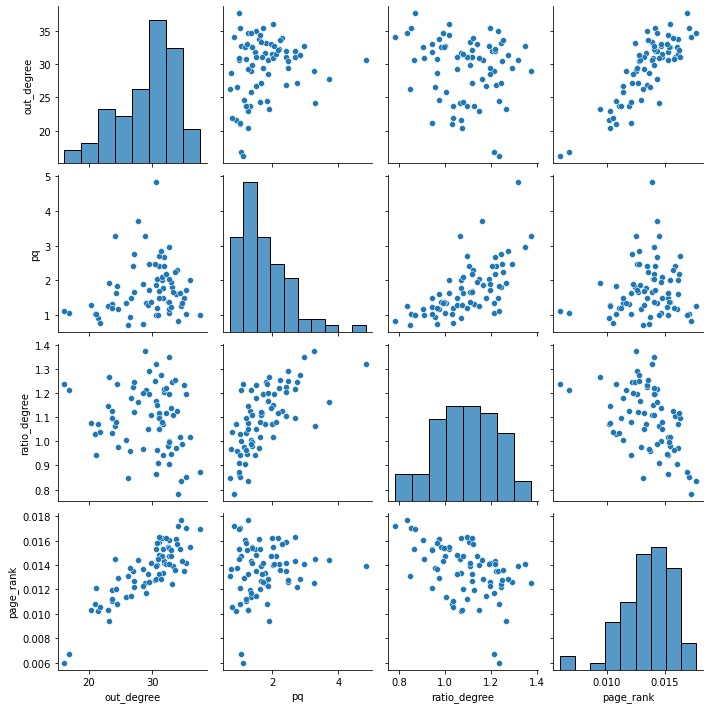

In [48]:
df_centrality = pd.DataFrame({"out_degree": mean_out_degree ,
                              "pq":mean_pq,
                              "ratio_degree": mean_ratio_degree,
                              "page_rank" :mean_page_rank })
sns.pairplot(df_centrality)
plt.savefig(fpath+"pairplot_avg_centrality.png")

### Rank the nodes based on above mentioned centralities

In [4]:
def rank_pq(A): #p_i by q_i, high to low
    N = len(A)
    
    centr_dict = {}
    for i in range(1,N+1):
        # either output node to be controlled for qi or input node to control i.e. pi
        e_i = compute_B(N, [i])
        
        # p_i
        W_i = solve_continuous_lyapunov(A, -np.matmul(e_i, e_i.T))
        p_i = np.trace(W_i)
        
        # q_i
        M_i = solve_continuous_lyapunov(A.T, -np.matmul(e_i, e_i.T))
        q_i = np.trace(M_i)
        
        centr_dict[i] = p_i/q_i
    sorted_d = dict( sorted(centr_dict.items(), key=operator.itemgetter(1),reverse=True)) # reverse = True -> h2l
    return sorted_d    
    
    

In [5]:
#A = A.T # A has to be original matrix without any transpose done in previous step
    
def rank_outDegree(A): # unweighted, low to high ranking 
    
    N = len(A)
    nodes = range(1,N+1)
    out_degree = np.sum(A!=0, axis=1).astype(int) # unweighted out-degree
    
    centr_dict = dict(zip(nodes, out_degree))
    sorted_d = dict( sorted(centr_dict.items(), key=operator.itemgetter(1),reverse=False)) # l2h
    
    return sorted_d
#rank_outDegree(A.T)
    

In [6]:
def rank_weight_OutbyIn_Degree(A): # weighted, high to low ranking 
    
    N = len(A)
    nodes = range(1,N+1)
    out_degree = np.sum(np.abs(A), axis=1) # weighted out-degree
    in_degree = np.sum(np.abs(A), axis=0) # weighted In-degree
    
    ratio = out_degree/in_degree
    
    
    centr_dict = dict(zip(nodes, ratio))
    sorted_d = dict( sorted(centr_dict.items(), key=operator.itemgetter(1),reverse=True)) # h2l
    
    return sorted_d


In [8]:
def rank_pageRank(A): # Unweighted, low to high
    #A = np.abs(A) # reason it doesn't converges is because of negative entries
    
    G = get_graph_from_adjacency(A)
    centr_dict = dict(nx.pagerank(G, alpha=0.85, tol=1e-06, max_iter=5000, weight="None"))
    
    
    # unweighted page rank
    sorted_d = dict( sorted(centr_dict.items(), key=operator.itemgetter(1),reverse=False)) # l2h
    return sorted_d

    

CPU times: user 34 µs, sys: 0 ns, total: 34 µs
Wall time: 96.8 µs


In [33]:
import operator

def Nodes_energy_relation(adj_original, centrality, seed=123):
    A =  adj_original.T    # should be transpose according to Barabasi 2011 paper
    N = len(A)# N=74 in our case
    
    if centrality=="random":
        np.random.seed(seed)
        control_nodes = list(range(1,N+1))
        # randomize the control nodes
        np.random.shuffle(control_nodes)
    else:
        if centrality=="pq":
            sorted_d = rank_pq(A)
        elif centrality=="out_degree":
            sorted_d = rank_outDegree(A.T) # A should be original matrix
        elif centrality=="ratio_degree":
            sorted_d = rank_weight_OutbyIn_Degree(A.T)
        elif centrality=="page_rank":
            sorted_d = rank_pageRank(A.T)    
            
        control_nodes = list(sorted_d.keys())    
    
    Num_control_nodes = []
    min_evals_W = []
    #avg_inv_evals_list=[]
    #median_inv_evals_list=[]
    
    while len(control_nodes)!=0:    
        Num_control_nodes.append(len(control_nodes))
        
        # compute B 
        # remember to sort the control nodes before constructing the input matrix B
        B = compute_B(N, sorted(control_nodes) )
    
        # check Kalman rank    
        C = controllability_matrix(A, B)
        rank_C = np.linalg.matrix_rank(C,tol=1E-50).item(0) # Full rank matrix 
        if rank_C!=N:
            print("rank_C != N for Nd = ",B.shape[1])
            continue
            
        # compute W
        W = solve_continuous_lyapunov(A, -np.matmul(B, B.T)) 
        
        # compute  e_min 
        min_evals_W.append( min(np.linalg.eigvals(W)) )
        
        # alternative to E_min
        
        # mean of inv of eigen values, 
        # avg_inv_evals_list.append(np.mean(np.linalg.eigvals(W)**-1) )
        
        # median of inv of eigen values, 
        #median_inv_evals_list.append(np.median(np.linalg.eigvals(W)**-1))
        
        # delete the control node which has lowest out degree.
        del control_nodes[-1]
    
    e_min_list = compute_e_min(min_evals_W)
    #avg_inv_evals = filter_avg_inv_evals(avg_inv_evals_list)    
    return (Num_control_nodes, e_min_list)#avg_inv_evals )

def compute_e_min(min_evals):
    # consider only real part of eigenvalues since there 
    # is numerically close to 0 for imaginary part
    min_evals = np.real(np.array(min_evals))
    
    # set all the eigen values less than 10^-12 as 10^-12 for plotting sake 
    min_evals[min_evals<1e-12]=1e-12
    
    e_min = np.array(min_evals)**-1
    return e_min


In [34]:
# use this function in case avg_inv_evals or median_inv_evals are computed instead of e_min

def filter_avg_inv_evals(avg_inv_evals):
    # convert it to array
    avg_inv_evals = np.array(avg_inv_evals)
    
    # set all complex to 10^12
    avg_inv_evals[np.iscomplex(avg_inv_evals)] = 10**12
    
    avg_inv_evals = np.real(avg_inv_evals)
    
    # set all numerically negative to 10^12
    avg_inv_evals[avg_inv_evals<0] = 10**12
    
    
    #  set all values greater than 10^12 to 10^12
    avg_inv_evals[avg_inv_evals>10**12] = 10**12
    
    return avg_inv_evals
 

In [10]:
path

'./SUBJ_LEMON_02//full_controllability/'

In [12]:
# Check whether the specified path exists or not
path = fpath+"full_controllability/"
isExist = os.path.exists(path)

if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(path)
    

In [ ]:
%%time
# avg 10 times over each subject for "random" case
seed_list = list(range(100,110,1))

subject_names = [file[:-4] for file in mat_files]


for centrality in ["random"]:
    
    arr = []
    for i in range(len(mat_files)):
        A = loadmat(fpath+mat_files[i])["A_sparse"]
        sub_arr = []
        
        for seed in seed_list:
            Num_control_nodes, e_min = Nodes_energy_relation(A, centrality=centrality, seed=seed)
            sub_arr.append(e_min)
        
        sub_arr = np.array(sub_arr )
        print(mat_files[i])
        arr.append(np.mean(sub_arr, axis=0 ) )

    # arr is of shape 23 x 74
    emin_23subcols_arr = np.array(arr).T  # 74 x 23 arr. 23 refers to 23 subjects
    
    # create a dataframe to store energy for 23 subjects and for varying no. of control inputs
    df_23subj = pd.DataFrame(emin_23subcols_arr, columns=subject_names)
    df_23subj.insert(0, "Num_control_nodes", Num_control_nodes)
    
    # save the dataframe
    #df_23subj.to_csv(fpath+"21Jan/"+centrality+".csv", index=False)
    df_23subj.to_csv(fpath+"full_controllability/"+centrality+".csv", index=False)
    
    

In [35]:
%%time

subject_names = [file[:-4] for file in mat_files]

for centrality in ["out_degree", "pq", "ratio_degree", "page_rank"]:
    
    arr = []
    for i in range(len(mat_files)):
        A = loadmat(fpath+mat_files[i])["A_sparse"]
        Num_control_nodes, e_min = Nodes_energy_relation(A, centrality=centrality)
        arr.append(e_min)

    # arr is of shape 23 x 74
    emin_23subcols_arr = np.array(arr).T  # 74 x 23 arr. 23 refers to 23 subjects
    
    # create a dataframe to store energy for 23 subjects and for varying no. of control inputs
    df_23subj = pd.DataFrame(emin_23subcols_arr, columns=subject_names)
    df_23subj.insert(0, "Num_control_nodes", Num_control_nodes)
    
    # save the dataframe
    df_23subj.to_csv(fpath+"full_controllability/"+centrality+".csv", index=False)


CPU times: user 11min 14s, sys: 6min 24s, total: 17min 38s
Wall time: 4min 39s


In [ ]:
# plotting the avg energy curves, averaged over 23 subjects
plt.figure(figsize=(15,7))

for centrality in ["out_degree", "pq", "ratio_degree", "page_rank", "random"]:
    
    df = pd.read_csv(fpath+"full_controllability/"+centrality+".csv")
    emin_avg = df.iloc[:,1:].mean(axis=1).tolist()
    Num_control_nodes = df.Num_control_nodes.tolist()
    plt.plot(Num_control_nodes, emin_avg,".-", label=centrality)

# magnifying a certain region    
#plt.ylim([1,10**7])
#plt.xlim([20,75])


plt.legend(loc="best", prop={"size":14})

plt.tick_params(labelsize=14)
plt.yscale("log")
plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.8)

plt.xlabel("No. of control inputs", size=15)
plt.ylabel("Avg. min. energy", size=15)
plt.title("Full controllability", size=16)

plt.savefig(fpath+"full_controllability/"+"full_controllability.png")


# Number of driver nodes vs sparsity of EC

In [9]:
# Code for Max matching

import pandas as pd
from networkx.algorithms import bipartite
from networkx.algorithms import components
import random
import copy


class max_match_directed:
    def __init__(self,dir_graph):#, position, label):
        self.dir_graph = dir_graph
        #self.position = position
        #self.label = label
        self.temp_d = dir_graph.copy()

    def info(self):
        print(nx.info(self.dir_graph))
    
    def degree_in_out(self):
        self.din = []
        self.dout = []
        for value in self.dir_graph.in_degree():
            self.din.append(value[1])
        for value in self.dir_graph.out_degree():
            self.dout.append(value[1])
        self.d_in = sum(self.din)/float(nx.number_of_nodes(self.dir_graph))
        self.d_out = sum(self.dout)/float(nx.number_of_nodes(self.dir_graph))
        return self.d_in, self.d_out
    
    def bipartition(self):
        #print("Nodes dgraph before:", self.dir_graph.nodes())
        self.Bip_rappr = nx.Graph()
        self.rel_nodes = {}
        self.n_nodes = len(nx.nodes(self.dir_graph))
        
        node_list_dir = list(nx.nodes(self.dir_graph))   
        for i,j in zip(node_list_dir,range(1,self.n_nodes+1)): #range(self.n_nodes):
            self.rel_nodes[i] = j
        #print("mapping",self.rel_nodes)
        
        self.DiG_rel = nx.relabel_nodes(self.dir_graph, self.rel_nodes)
        self.bipart_DiG_rel = []
        
        for i in self.DiG_rel.edges():
            #print('edge',i)
            self.bipart_DiG_rel.append((i[0],-i[1]))
            #print('create edge',i[0],-i[1])
        self.Bip_rappr.add_edges_from(self.bipart_DiG_rel)
        #print("dgraph edges 1:",self.dir_graph.edges())
        #print("dgraph edges 2:",self.DiG_rel.edges())
        #print("bip_graph edges: ",self.Bip_rappr.edges())
        #print("Nodes dgraph after:", self.dir_graph.nodes())
        
        #return self.Bip_rappr
        
    def connection(self):
        if components.is_connected(self.Bip_rappr)==False:
            #self.n_connected_components = len(list(nx.connected_component_subgraphs(self.Bip_rappr)))
            self.n_connected_components = len(list(self.Bip_rappr.subgraph(c).copy()\
                                                   for c in nx.connected_components(self.Bip_rappr)))
            
            #print(self.n_connected_components)
        else:
            print('is connected')
            
            
    def max_matching_bipartite(self):
        self.match_list_reduced= []
        self.matched_edges_b = []
        if nx.is_connected(self.Bip_rappr) == False:
            #self.graphss = list(nx.connected_component_subgraphs(self.Bip_rappr))
            self.graphss = list(self.Bip_rappr.subgraph(c).copy() for c in nx.connected_components(self.Bip_rappr))
            #print("List of connected components:",[c.nodes() for c in (self.graphss)])
            
            for i in range(len(self.graphss)):
                self.matching = bipartite.matching.hopcroft_karp_matching(self.graphss[i])
                #print("Hopcroft matching:",self.matching)
                #print('matching',self.matching)
                for key in self.matching:
                    if key>0:
                        self.match_list_reduced.append(self.matching[key])
                        self.matched_edges_b.append((key,self.matching[key]))
                #print("matched edges b:", self.matched_edges_b)
        else: 
            bipartite.maximum_matching(self.Bip_rappr)
            self.matching = bipartite.matching.hopcroft_karp_matching(self.Bip_rappr)
            for key in self.matching:
                #print('matching',self.matching)
                if key> 0:
                    self.match_list_reduced.append(self.matching[key])
                    self.matched_edges_b.append((key,self.matching[key]))
        
        #print("matched edges b:", self.matched_edges_b)
        #print("matched nodes:", self.match_list_reduced)

        self.match_list_reduced.sort()
        
        self.unmatched_edges_b = []
        self.unmatched_edges_b_temp = []
        self.unmatched_nodes_b = []

        self.temp_b = self.Bip_rappr.copy()
        self.temp_b.remove_edges_from(self.matched_edges_b)
        self.unmatched_edges_b_temp = list(self.temp_b.edges)
        self.temp_b.remove_nodes_from(self.match_list_reduced)
        self.unmatched_nodes_b = list(self.temp_b.nodes)

        #print("unmatched nodes brefore:", self.unmatched_nodes_b)
        
        
        for edges in self.unmatched_edges_b_temp:
            if edges[0]>0 and edges[1]<0:
                self.unmatched_edges_b.append(edges)
            elif edges[0]<0 and edges[1]>0:
                self.unmatched_edges_b.append((edges[1],edges[0]))
            else:
                print('probLLAMA')
        
        #print("unmatched nodes after:", self.unmatched_nodes_b)
        #print("unmatched edges after:", self.unmatched_edges_b)

        
        #print('matched nodes neg bip',self.match_list_reduced)
        #print('unmatched nodes neg bip',self.unmatched_nodes_b)
        #print('matched edges bip',self.matched_edges_b)
        #print('unmatched edge b',self.unmatched_edges_b)

        
    def max_matching_digraph(self):
        self.match_nodes_d = []
        self.unmatch_nodes_d = []
        for node in self.match_list_reduced:
            #self.match_nodes_d.append(-node-1) # remember this was from old code of Samir's student
            self.match_nodes_d.append(-node)
        self.temp_d.remove_nodes_from(self.match_nodes_d)
        for node in self.temp_d.nodes:
            self.unmatch_nodes_d.append(node)
            
        self.unmatched_edges_d = []
        self.matched_edges_d = []

        for edges in self.unmatched_edges_b:
    #        self.unmatched_edges_d.append((edges[0]-1,-edges[1]-1))
            self.unmatched_edges_d.append((edges[0],-edges[1]))
    
        for edges in self.matched_edges_b:
            #self.matched_edges_d.append((edges[0]-1,-edges[1]-1))
            self.matched_edges_d.append((edges[0],-edges[1]))
        
        self.N_D= len(self.unmatch_nodes_d) 
        self.ND = str(self.N_D)

        #print('matched nodes', self.match_nodes_d)
        #print('unmatched nodes',self.unmatch_nodes_d)    
        #print('N_D:',len(self.unmatch_nodes_d)) #AGGIUNGI I NODI ISOLATI
        #print('unmatched edges digraph',self.unmatched_edges_d)
        #print('matched edges digraph',self.matched_edges_d)
        return self.match_nodes_d, self.unmatch_nodes_d,self.N_D, self.matched_edges_d, self.unmatched_edges_d
 

In [8]:
def max_matching_info(G):
    m = max_match_directed(G)#, position, label)
    d_in,d_out = m.degree_in_out()
    m.bipartition()
    #m.connection()

    m.max_matching_bipartite()

    matched_nodes, unmatched_nodes, N_D, matched_edges, unmatched_edges = m.max_matching_digraph()
    return matched_nodes, unmatched_nodes, N_D, matched_edges, unmatched_edges
        


In [7]:
# Function to sparsify the EC matrix by killing the entries of setting the entries to 0

def kill_entries(A,method='random', f=0.1,random_seed=123):
    if method=='random':
    
        np.random.seed(random_seed)
        # consider the indices of random matrix which are non zero. 
        # It is of form (num x 2), cols are index pos of matrix
        ind_mat = np.argwhere(A)

        # reshuffle them
        np.random.shuffle(ind_mat)

        # number of non zero entries of A
        num_nonZero_A = ind_mat.shape[0]

        # number of entries to be killed
        num_entries_to_kill = int(f*num_nonZero_A)

        # initialize A_sparse to A before we kill the entries
        A_sparse = np.zeros(A.shape)
        A_sparse = deepcopy(A)

        # always select first num_entries_to_kill from ind_mat
        for i in range(num_entries_to_kill):
            A_sparse[ind_mat[i][0],ind_mat[i][1]] = 0

        return A_sparse

    elif method=='absmin':
        B = deepcopy(A)
        B=B-np.diag(np.diag(B))
        B=np.abs(A)    

        th = np.percentile(B[B>0],100*f)

        A_sparse = deepcopy(A)

        A_sparse[np.where(np.abs(A_sparse)<th)]=0 

        return A_sparse

    elif method=='absmax':
        B = deepcopy(A)
        B=B-np.diag(np.diag(B))
        B=np.abs(A)    

        th = np.percentile(B[B>0],100-100*f)

        A_sparse = deepcopy(A)

        A_sparse[np.where(np.abs(A_sparse)>=th)]=0 

        return A_sparse

    elif method=='min':
        B = deepcopy(A)
        B=B-np.diag(np.diag(B))
            

        th = np.percentile(B[B!=0],100*f)
        #print("threshold: ",th)
        #print("min B: ",np.min(B.flatten()))

        A_sparse = deepcopy(A)

        A_sparse[np.where(A_sparse<th)]=0 

        return A_sparse

    elif method=='max':
        B = deepcopy(A)
        B=B-np.diag(np.diag(B))

        th = np.percentile(B[B!=0],100-100*f)

        A_sparse = deepcopy(A)

        A_sparse[np.where(A_sparse>=th)]=0 

        return A_sparse
    else:
        print("Error")
    

In [6]:
# Assign the weights from original EC matrix to randomized matrix A_rand

def assign_weights_to_randMatrices(A, A_rand, seed=123):
    
    # select all the non zero values of A
    nonZero_A = np.array(A[np.nonzero(A)])
    np.random.seed(seed)
    # reshuffle them
    np.random.shuffle(nonZero_A)
    
    # consider the indices of random matrix which are non zero. 
    # It is of form (num x 2), cols are index pos of matrix
    ind_mat = np.argwhere(A_rand)
    
    # length of non zero entries of A_rand
    num_nonZero_A_rand = len(A_rand[np.nonzero(A_rand)])
    #print(num_nonZero_A_rand)
    
    A_weighted_rand = np.zeros(A_rand.shape)
    for j in range(num_nonZero_A_rand): 
        # assign shuffles values of A to A_rand
        if j >=len(nonZero_A):
            break
        else:
            A_weighted_rand[ind_mat[j][0],ind_mat[j][1]] = nonZero_A[j]
        
    return A_weighted_rand



In [ ]:


import random

def sparseMatrix_controllability(adj_original,method='random', graph_type="original",\
                                 input_matrix="B_unmatched",seed=123):
    #adj_original = np.load(adj_matfile) 
    A =  adj_original.T# should be transpose according to Barabasi 2011 paper
    N = len(A)# N=74 in our case
    #print("Max eval A_original:", max(np.real(np.linalg.eigvals(A))))
    
    # Check for stability of LTI equation using the eigen values of A
    max_evals_A_sp = [] # list of max eigen values of sprices of A
    min_evals_W_sp = [] # list of max eigen values of sprices of A
    
    Nd_list = []
    kalman_rank_list = []
    density_list = []
    
    fraction_removed = np.linspace(0.1,0.95,50)#np.arange(0.1, 0.85,0.05) 
    
    max_eval_A = max(np.real(np.linalg.eigvals(A)))
    #print("Max value of A: ", max_eval_A)
    
    ############ B_max ######################
    if input_matrix == "B_max":

        A_sp = kill_entries(A-np.diag(np.diag(A)), f=0.95, method=method)
        #print("Non zero A_sp, max killing ",np.argwhere(A_sp))


        # reassign N again
        N = A_sp.shape[0]

        # compute unmatched nodes 
        G = get_graph_from_adjacency( A_sp.T -np.diag(np.diag(A_sp.T))) # while computing unmatched nodes, should be original A  

        if graph_type=="erdos":
                # Null model 1
                # Erdos-renyi graph
                #print("Entries before erdos: ", len(G.nodes()))
                N, p = len(A_sp), nx.density(G)
                G_erdos = nx.erdos_renyi_graph(n=N, p=p, seed=seed, directed=True)
                A_erdos = np.array(nx.adjacency_matrix(G_erdos).todense())
                A_erdos = assign_weights_to_randMatrices(A_sp, A_erdos, seed=seed)
                # remove all unwanted diagonal entries if present
                A_erdos = A_erdos-np.diag(np.diag(A_erdos)) 

                A_sp = deepcopy(A_erdos)
                G = deepcopy(G_erdos)
                #print("Entries after erdos: ", len(G.nodes()))


        elif graph_type=="dirConfig":
                # Null model 2
                # Directed configuration model
                in_deg = list(dict(G.in_degree()).values())
                out_deg = list(dict(G.out_degree()).values())
                G_dirConfig = nx.directed_configuration_model(in_deg, out_deg,seed=seed)

                A_dirConfig = np.array(nx.adjacency_matrix(G_dirConfig).todense())

                A_dirConfig = assign_weights_to_randMatrices(A_sp, A_dirConfig, seed=seed)
                # remove all unwanted diagonal entries if present
                A_dirConfig = A_dirConfig-np.diag(np.diag(A_dirConfig)) 


                A_sp = deepcopy(A_dirConfig)
                G = deepcopy(G_dirConfig)

        unmatched_nodes = max_matching_info(G)[1]
        print("Max driver nodes for B_max: ", len(unmatched_nodes))

        # compute B max
        B = compute_B(N, unmatched_nodes)
        
    elif input_matrix=="B_50percent":
        random.seed(seed)
        driver_nodes = random.sample(range(1,N+1), int(0.5*N))
        B = compute_B(N, driver_nodes)


    ##################################################################
    #diag_entries = np.diag(np.diag(A))
        
    for i in fraction_removed:    
        
        # A with diagonal entries 0
        #A_sp = kill_entries(A, i) #+ np.diag(np.diag(A))#till 0.9
        A_sp = kill_entries(A-np.diag(np.diag(A)), f=i,method=method) #+ np.diag(np.diag(A))#till 0.9
        
        
        # reassign N again
        N = A_sp.shape[0]
        
        # transpose is done, since it has to be original matrix when converting to a network
        G = get_graph_from_adjacency( A_sp.T-np.diag(np.diag(A_sp.T)) )  
        
        if graph_type=="erdos":
            # Null model 1
            # Erdos-renyi graph
            N, p = len(A_sp), nx.density(G)
            G_erdos = nx.erdos_renyi_graph(n=N, p=p, seed=seed, directed=True)
            A_erdos = np.array(nx.adjacency_matrix(G_erdos).todense())
            A_erdos = assign_weights_to_randMatrices(A_sp, A_erdos, seed=seed)
            # remove all unwanted diagonal entries if present
            A_erdos = A_erdos-np.diag(np.diag(A_erdos)) 
            
            A_sp = deepcopy(A_erdos)
            G = deepcopy(G_erdos)
        
        elif graph_type=="dirConfig":
            # Null model 2
            # Directed configuration model
            in_deg = list(dict(G.in_degree()).values())
            out_deg = list(dict(G.out_degree()).values())
            G_dirConfig = nx.directed_configuration_model(in_deg, out_deg,seed=seed)

            A_dirConfig = np.array(nx.adjacency_matrix(G_dirConfig).todense())

            A_dirConfig = assign_weights_to_randMatrices(A_sp, A_dirConfig, seed=seed)
            # remove all unwanted diagonal entries if present
            A_dirConfig = A_dirConfig-np.diag(np.diag(A_dirConfig)) 
            
            
            A_sp = deepcopy(A_dirConfig)
            G = deepcopy(G_dirConfig)
        
        # compute unmatched nodes 
        
        unmatched_nodes = max_matching_info(G)[1]
        Nd_list.append( len(unmatched_nodes))

        # compute density
        density_list.append( nx.density(G) )
        
        if input_matrix=="B_unmatched":    
            # compute B
            B = compute_B(N, unmatched_nodes)

        ####### stabilize the LTI before proceeding to check Kalman controllability  ####

        A_sp = A_sp + np.diag(np.diag(A)) 

        # check if max eval of A is negative or not
        max_evals_A_sp.append( max(np.real(np.linalg.eigvals(A_sp)))  )

        # check Kalman rank    
        C = controllability_matrix(A_sp, B)
        rank_C = np.linalg.matrix_rank(C,tol=1E-50).item(0) # Full rank matrix 
        if rank_C!=N:
            kalman_rank_list.append(False)
        else:
            kalman_rank_list.append(True)

        # compute W
        #W = solve_continuous_lyapunov(A_sp, -np.matmul(B, B.T)) 

        # compute avg controllability 
        #avg_contr_list.append( np.trace(W) )

        # compute  e_min if possible
        #min_evals_W_sp.append( min(np.linalg.eigvals(W)) )

            
            
    #return (max_evals_A_sp, min_evals_W_sp, Nd_list, kalman_rank_list, \
    #        avg_contr_list,density_list, fraction_removed)
    return (Nd_list, fraction_removed)

    

In [ ]:
%%time
# unmatched nodes
# DCM sparse

fpath = "./SUBJ_LEMON_02/"
mat_files = [f for f in sorted_alphanumeric(os.listdir(fpath)) if f.endswith('.mat') 
         and os.path.isfile(os.path.join(fpath, f))]

Nd_original_total = []
Nd_erdos_total = []
Nd_dirConfig_total = []

#adj_dense = loadmat( fpath+mat_files[0] )["A"]
for i in range(len(mat_files)):
    #print(mat_files[i][:-4])
    #diag_entries = np.diag(adj_dense)

    #A = loadmat( path )["A_sparse"]
    #A = A + np.diag(diag_entries )
    A = loadmat( fpath+mat_files[i] )["A_sparse"]


    sp_info = sparseMatrix_controllability(A,method='absmax', graph_type="original",\
                                     input_matrix="B_unmatched",seed=123)
    Nd_original_list = sp_info[0]
    #e_min_original = compute_e_min(sp_info[1])
    Nd_original_total.append(Nd_original_list)
    
    fraction_removed = sp_info[-1]

    sp_info = sparseMatrix_controllability(A,method='absmax', graph_type="erdos",input_matrix="B_unmatched",seed=123)
    Nd_erdos_list = sp_info[0]
    #e_min_erdos = compute_e_min(sp_info[1])
    Nd_erdos_total.append(Nd_erdos_list)

    sp_info = sparseMatrix_controllability(A,method='absmax', graph_type="dirConfig",input_matrix="B_unmatched",seed=123)
    Nd_dirConfig_list = sp_info[0]
    #e_min_dirConfig = compute_e_min(sp_info[1])
    Nd_dirConfig_total.append(Nd_dirConfig_list)

    

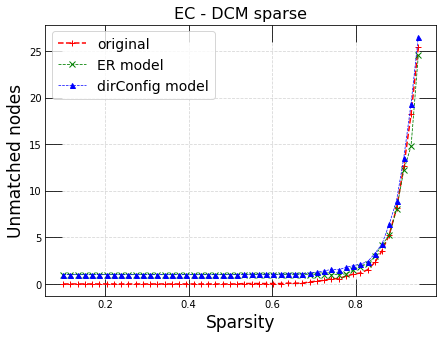

In [33]:
# plot fraction removed or sparsity VS Number of unmatched nodes


Nd_original_list = np.mean(np.array(Nd_original_total),axis=0)
Nd_erdos_list = np.mean(np.array(Nd_erdos_total),axis=0)
Nd_dirConfig_list = np.mean(np.array(Nd_dirConfig_total),axis=0)

plt.figure(figsize=(7,5))

plt.plot(fraction_removed,Nd_original_list,'+--',markersize=6,label='original', color="red")
plt.plot(fraction_removed,Nd_erdos_list,'x--',lw=0.8,markersize=6,label='ER model', color="green")
plt.plot(fraction_removed,Nd_dirConfig_list,'^--',lw=0.7,markersize=5,label='dirConfig model', color="blue")

plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.5)
plt.legend(loc="best", prop={"size":14})

plt.xlabel("Sparsity",size=17)
plt.ylabel("Unmatched nodes",size=17)
plt.tick_params(size=17)


plt.title("EC - DCM sparse",size=16)
plt.savefig(fpath+"21Jan/sparsity_vs_Nd_23Sub_avg.png")
plt.show()    